Importing different Python libraries

In [179]:
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
sns.set_style("whitegrid")
from datetime import date
import calendar

Reading the csv file for the Medical Appointment No Show dataset.

In [180]:
noShow = pds.read_csv('KaggleV2-May-2016.csv')
print(noShow.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

Getting the Structure of the Dataset

In [181]:
noShow.shape

(110527, 14)

Renaming few columns

In [182]:
noShow.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Handicap',
                         'No-show': 'NoShowStatus'}, inplace = True)
print(noShow.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'NoShowStatus'],
      dtype='object')


For convenience, I am going to convert the ScheduledDay and AppointmentDay columns into datetime64 format.

In [183]:
noShow.ScheduledDay = noShow.ScheduledDay.apply(np.datetime64)
noShow.AppointmentDay = noShow.AppointmentDay.apply(np.datetime64)

print(noShow.ScheduledDay.head())
print(noShow.AppointmentDay.head())

0   2016-04-29 18:38:08
1   2016-04-29 16:08:27
2   2016-04-29 16:19:04
3   2016-04-29 17:29:31
4   2016-04-29 16:07:23
Name: ScheduledDay, dtype: datetime64[ns]
0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2016-04-29
Name: AppointmentDay, dtype: datetime64[ns]


Creating a new column for the Appointment Day of the week

In [184]:
def convertToDay(timestamp):
    my_date = timestamp
    return calendar.day_name[my_date.weekday()]
noShow['DayOfWeek'] = noShow.AppointmentDay.apply(convertToDay)
noShow['DayOfWeek'].head()

0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
Name: DayOfWeek, dtype: object

Checking for any null values in any of the rows.

In [185]:
print (noShow.isnull().sum())

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SMS_received      0
NoShowStatus      0
DayOfWeek         0
dtype: int64


Checking for any anomolies in the data of different attributes

In [186]:
print('Age:',sorted(noShow.Age.unique()))
print('Gender:',noShow.Gender.unique())
print('Diabetes:',noShow.Diabetes.unique())
print('Alcoholism:',noShow.Alcoholism.unique())
print('Hypertension:',noShow.Hypertension.unique())
print('Handicap:',noShow.Handicap.unique())
print('Scholarship:',noShow.Scholarship.unique())
print('NoShowStatus:',noShow.NoShowStatus.unique())
print('DayOfWeek:',noShow.DayOfWeek.unique())

Age: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]
Gender: ['F' 'M']
Diabetes: [0 1]
Alcoholism: [0 1]
Hypertension: [1 0]
Handicap: [0 1 2 3 4]
Scholarship: [0 1]
NoShowStatus: ['No' 'Yes']
DayOfWeek: ['Friday' 'Tuesday' 'Monday' 'Wednesday' 'Thursday' 'Saturday']


It is clear that we do not have any NaNs anywhere in the data. However, we do have some impossible ages such as -1, and some pretty absurd ages such as 100 and beyond. I do admit that it is possible to live 113 years and celebrate living so long, and some people do live that long, but most people don't. So I will treat the ages greater than 95 as outliers.

Once I have made my assumptions, it is time to remove the impossible and the absurd from the data.

In [187]:
noShow = noShow[(noShow.Age >= 0) & (noShow.Age <= 95)]

As the Data Wrangling phase is done, now lets analyze the data for any correlation.

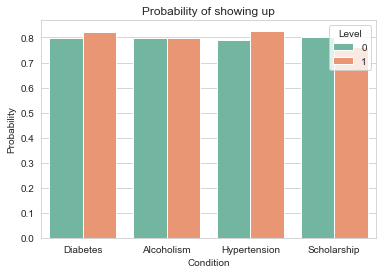

In [188]:
def probStatusCategorical(group_by):
    rows = []
    for item in group_by:
        for level in noShow[item].unique():
            row = {'Condition': item}
            total = len(noShow[noShow[item] == level])
            n = len(noShow[(noShow[item] == level) & (noShow.NoShowStatus == 'No')])
            row.update({'Level': level, 'Probability': n / total})
            rows.append(row)
    return pds.DataFrame(rows)

sns.barplot(data = probStatusCategorical(['Diabetes', 'Alcoholism', 'Hypertension','Scholarship']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()


Though there aren't much differences in people showing up for Appointment or not, but we can deduce that people with Hypertension are having slightly more probablility of showing up than people who don't. Also, people who are having Scholarship are less likely to show up for an Appointment than the people who don't. 

In [189]:
def probStatus(dataset, group_by):
    df = pds.crosstab(index = dataset[group_by], columns = dataset.NoShowStatus).reset_index()
    df['probShowUp'] = df['No'] / (df['Yes'] + df['No'])
    return df[[group_by, 'probShowUp']]

C:\Users\amari\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


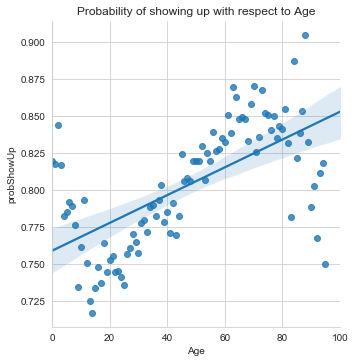

In [190]:
sns.lmplot(data = probStatus(noShow, 'Age'), x = 'Age', y = 'probShowUp', fit_reg = True)
plt.xlim(0, 100)
plt.title('Probability of showing up with respect to Age')
plt.show()

Though there are few outliers, you can observe the trend. As age increases the probability of a person showing up for an appointment increases. It is a linear dependency.

In [191]:
print('Number of Male patients:', sum(noShow.Gender == 'M'),
      '\nNumber of Female patients:', sum(noShow.Gender == 'F') )

Number of Male patients: 38678 
Number of Female patients: 71802


As you can clearly see, there are more Female patients than that of Male patients. This infers that Females are more concious about their health or Females are more prone to sickness.

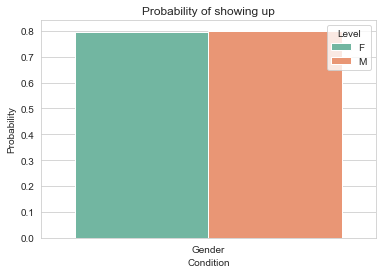

In [192]:
sns.barplot(data = probStatusCategorical(['Gender']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

There isn't much biasing between the genders when it comes to the probability of showing up for an appointment.

Text(0.5, 1.0, 'Women visit the doctor more often')

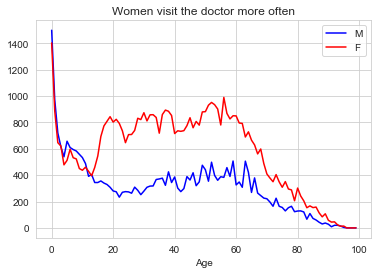

In [193]:
df = noShow[noShow.NoShowStatus == 'No']
range_df = pds.DataFrame()
range_df['Age'] = range(100)
men = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'M')]))
women = range_df.Age.apply(lambda x: len(df[(df.Age == x) & (df.Gender == 'F')]))
plt.plot(range(100),men, 'b')
plt.plot(range(100),women, color = 'r')
plt.legend(['M','F'])
plt.xlabel('Age')
plt.title('Women visit the doctor more often')

Women are twice as likely to visit the doctor
But this effect is true only from a certain age.

Until the age of 14, boys and girls attend the doctor similarly. Starting from around that age, however, there are more than 2.5 woman visits for every man visit.

Possible explanations:

1) Since the difference starts when approaching puberty, it might be due the different care that males and females seek regarding their reproductive system.

2) Men and women might suffer from different medical conditions that would require a different visiting frequency.

3) A difference in lifestyle that can allow women more visits

We don't have enough data for a conclusive statement. but let's see of any of the conditions that are detailed in the data can explain or partially explain the difference.

Maybe we can detect some differences in the registration hour, which can possibly be a proxy to the life style? for instance - would give us a sense on when are men and women slightly less occupied and therefore can engage in appointing a meeting?

In [194]:
noShow['ScheduledDay']=noShow.loc[:,'ScheduledDay'].astype(str)
df['Time'] = noShow['ScheduledDay'].apply(lambda x: int(x[11:13]))

C:\Users\amari\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


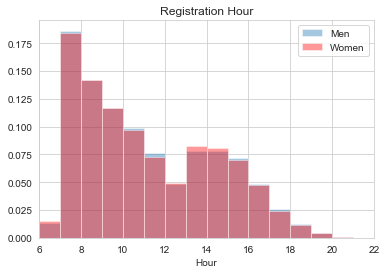

In [195]:
sns.distplot(df.Time[df.Gender == 'M'], bins = range(24),norm_hist = True, kde = False)#, barwidth = 0.5)#, kde = False)
sns.distplot(df.Time[df.Gender == 'F'], bins = range(24),norm_hist = True, kde = False, color = 'r')
plt.xlim([6,22])
plt.title('Registration Hour')
plt.xlabel('Hour')
plt.legend(['Men','Women'])

Men prefer to call the doctor in the morning, women in the afternoon.
While the difference is of course very small, it is consistent and clustered along the day: from 12 to 17, a larger percent of women register to the doctor (compared to men). Whereas from 7 to 12, it is the other way around.

It is possible, though very far from certain, that the difference results from the fact that it is probably more likely for women to be home earlier, on average, than men. If the visit hours correspond with that - that is, more visits in the afternoon, this can be one (though certainly not the only one) of the root causes for the difference in the total number of visits, but this piece of data is missing in our dataset. however - this explanation cannot really explain why the gap is created around the age of 14, way before men and women start their careers.

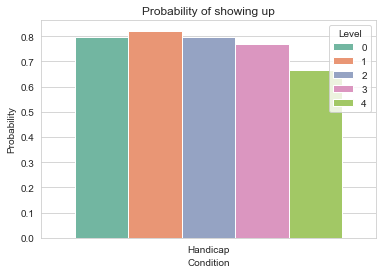

In [196]:
sns.barplot(data = probStatusCategorical(['Handicap']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

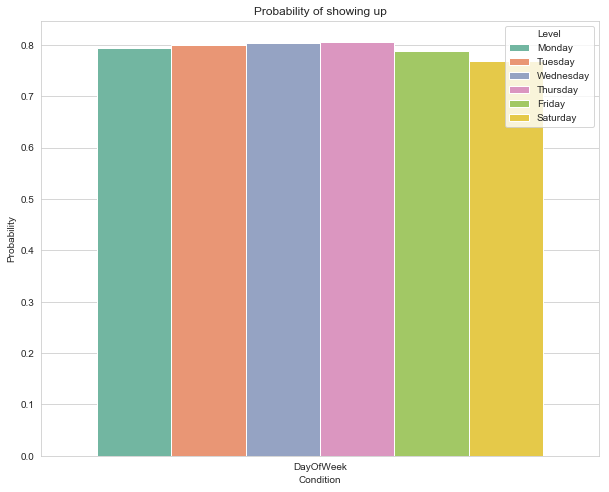

In [197]:
plt.figure(figsize=(10,8))
sns.barplot(data = probStatusCategorical(['DayOfWeek']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2',
           hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                       'Saturday'])
plt.title('Probability of showing up')
plt.ylabel('Probability')
plt.show()

As you can observe from the above plot that the probability of patient showing up for an appointment increases till mid week and decreases towards weekends. It might imply that people have many plans on the weekends and that might be a reason for the decline in the probablity of showing up for an appointment.